In [6]:
# We use the autoreload extension that comes with ipython to automatically reload modules when
# the code in them changes.

# import the jupyter extension
%load_ext autoreload
# set it to only reload the modules imported
%autoreload 1

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
import ray
import pandas as pd

from hamilton import base, driver
from hamilton.plugins import h_ray

In [8]:
%%writefile spend_calculations.py

import pandas as pd

def spend(spend_location: str) -> pd.Series:
    """Dummy function showing how to wire through loading data.

    :param spend_location:
    :return:
    """
    return pd.Series([10, 10, 20, 40, 40, 50])


def signups(signups_location: str) -> pd.Series:
    """Dummy function showing how to wire through loading data.

    :param signups_location:
    :return:
    """
    return pd.Series([1, 10, 50, 100, 200, 400])


def avg_3wk_spend(spend: pd.Series) -> pd.Series:
    """Rolling 3 week average spend."""
    return spend.rolling(3).mean()


def spend_per_signup(spend: pd.Series, signups: pd.Series) -> pd.Series:
    """The cost per signup in relation to spend."""
    return spend / signups


def spend_mean(spend: pd.Series) -> float:
    """Shows function creating a scalar. In this case it computes the mean of the entire column."""
    return spend.mean()


def spend_zero_mean(spend: pd.Series, spend_mean: float) -> pd.Series:
    """Shows function that takes a scalar. In this case to zero mean spend."""
    return spend - spend_mean


def spend_std_dev(spend: pd.Series) -> float:
    """Function that computes the standard deviation of the spend column."""
    return spend.std()


def spend_zero_mean_unit_variance(spend_zero_mean: pd.Series, spend_std_dev: float) -> pd.Series:
    """Function showing one way to make spend have zero mean and unit variance."""
    return spend_zero_mean / spend_std_dev

Overwriting spend_calculations.py


In [9]:
%aimport spend_calculations

# Set up the driver, input and output columns

config = {  # could load data here via some other means, or delegate to a module as we have done.
        # 'signups': pd.Series([1, 10, 50, 100, 200, 400]),
        "signups_location": "some_path",
        # 'spend': pd.Series([10, 10, 20, 40, 40, 50]),
        "spend_location": "some_other_path",
    }
adapter = h_ray.RayGraphAdapter(result_builder=base.PandasDataFrameResult())
dr = driver.Driver(config, spend_calculations, adapter=adapter)
output_columns = [
    "spend",
    "signups",
    "avg_3wk_spend",
    "spend_per_signup",
    "spend_zero_mean_unit_variance",
]

In [10]:
# Execute the driver.
df = dr.execute(output_columns)
print(df)

2023-09-18 19:28:07,329	INFO worker.py:1621 -- Started a local Ray instance.


   spend  signups  avg_3wk_spend  spend_per_signup  \
0     10        1            NaN            10.000   
1     10       10            NaN             1.000   
2     20       50      13.333333             0.400   
3     40      100      23.333333             0.400   
4     40      200      33.333333             0.200   
5     50      400      43.333333             0.125   

   spend_zero_mean_unit_variance  
0                      -1.064405  
1                      -1.064405  
2                      -0.483821  
3                       0.677349  
4                       0.677349  
5                       1.257934  


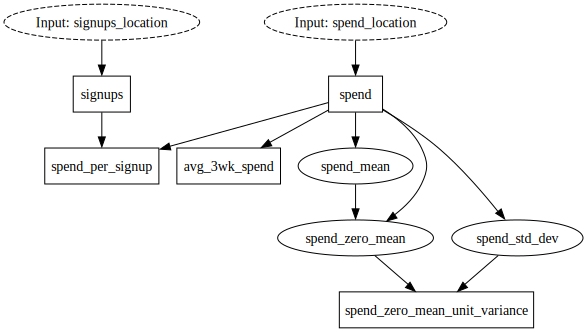

In [11]:
# To visualize do `pip install "sf-hamilton[visualization]"` if you want these to work
dr.visualize_execution(output_columns)

In [12]:
ray.shutdown()